### dataset : https://www.kaggle.com/competitions/zaka-ambassadors-egypt-vehicle-recognition/data

In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
from tensorflow.python.client import device_lib
# plotting
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import visualkeras
# images
import matplotlib.image as mpimg

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/train.csv')
test = pd.read_csv('/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/test.csv')
train

path  class
0       train/SUV/ca6db841594dc9da2de6a21b25e505e5.jpg      0
1       train/SUV/49173b67fddc75434ba8f3a3a6d378d0.jpg      0
2       train/SUV/a1aee21791edd791022e0c8b250f2d7e.jpg      0
3       train/SUV/48208b4d8cd461a809453588c7b09320.jpg      0
4       train/SUV/b221c3a7315d9d2a4d999a890df0097e.jpg      0
...                                                ...    ...
1395  train/truck/9da0a519d5061b53286b9f2e8263dd0f.jpg      9
1396  train/truck/32aa03fcb2357683b9e0ea416b1dcc70.jpg      9
1397  train/truck/beea9c8796c1cd45a90683bc220aeaeb.jpg      9
1398  train/truck/f5579a2ea30a7f8421a5e34fd9e32d61.jpg      9
1399  train/truck/b7a4b53dc5610d59f1fdf51639a4ef45.jpg      9

[1400 rows x 2 columns]

In [6]:
# this function prints the number of images for each class
def num_img (df):
 
    col_names = ['SUV','bus','family sedan','fire engine','heavy truckv','jeep','minibus','racing car','taxi','truck']
    unique_values = df['class'].value_counts(ascending = False)
    
    x = pd.DataFrame({ "Class" : col_names, "number of images" : unique_values})
    
    print(x)
num_img(train)

              Class  number of images
class                                
0               SUV               140
1               bus               140
2      family sedan               140
3       fire engine               140
4      heavy truckv               140
5              jeep               140
6           minibus               140
7        racing car               140
8              taxi               140
9             truck               140


In [7]:
train.iloc[0, 0]

'train/SUV/ca6db841594dc9da2de6a21b25e505e5.jpg'

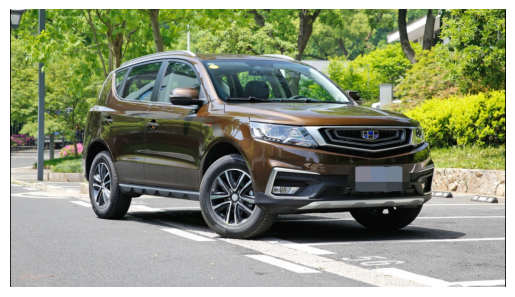

In [10]:
# /kaggle/input/vehicle-recognition/train/content/train
img = mpimg.imread('/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/train/content/'+train.iloc[0, 0])
# Display the image
plt.imshow(img)
plt.axis('off')  
plt.show()

In [12]:
train_path_perfix = "/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/train/content/"
test_path_perfix = "/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/test/content/"

CLASSES = {
'SUV': 0,
'bus': 1,
'family sedan': 2,
'fire engine': 3,
'heavy truck': 4,
'jeep': 5,
'minibus': 6,
'racing car': 7,
'taxi': 8,
'truck': 9
}

In [13]:
def show_images(n, dataset, base_path=train_path_perfix, class_encoded=None, MAX_IMGS=20, num_cols=10):
    if n <= MAX_IMGS:
        # Filter by class if class_label is provided
        if class_encoded is not None:
            dataset = dataset[dataset['class'] == class_encoded]

# Get the first n image paths
        images = dataset.iloc[:n].values

        num_rows = (n + num_cols - 1) // num_cols  # Calculate the number of rows needed
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows), dpi=150)

        ax = ax.flatten()  # Flatten the axes array

        for i in range(n):
            img_path = base_path + images[i][0]  # Assuming the file path is in the first column
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f"{i+1}")  # Add title with image number
            ax[i].axis('off')

# Hide any unused subplots
        for j in range(n, num_rows * num_cols):
            ax[j].axis('off')

        plt.show()
    else:
        print('Invalid number of images')

Examples of [SUV] cars images


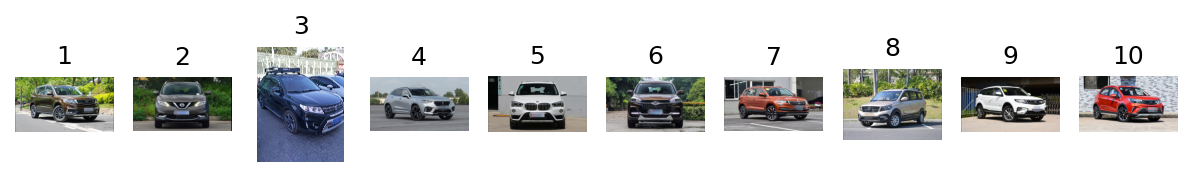

Examples of [bus] cars images


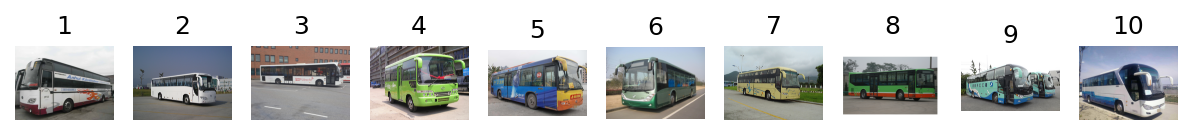

Examples of [family sedan] cars images


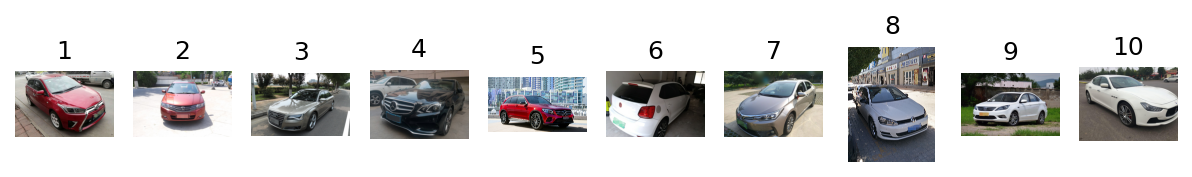

Examples of [fire engine] cars images


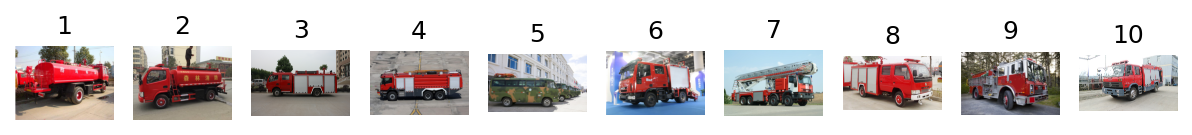

Examples of [heavy truck] cars images


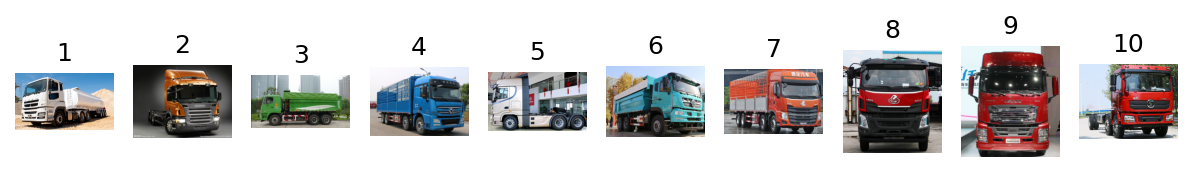

Examples of [jeep] cars images


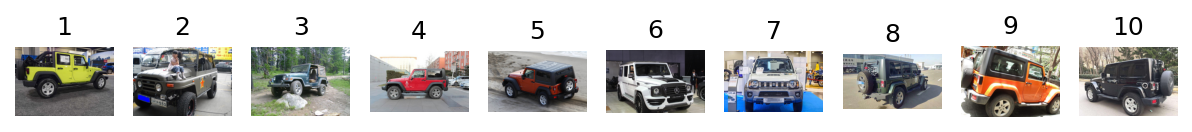

Examples of [minibus] cars images


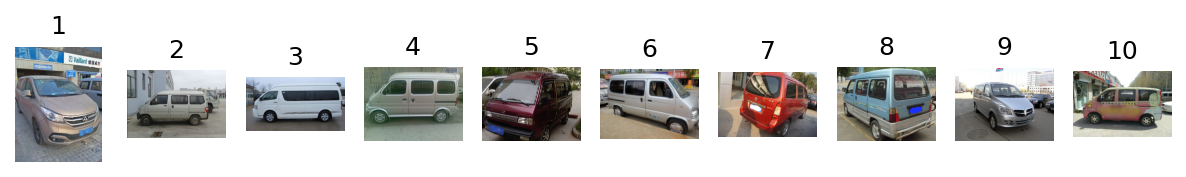

Examples of [racing car] cars images


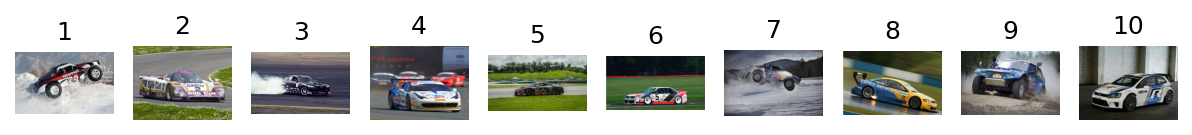

Examples of [taxi] cars images


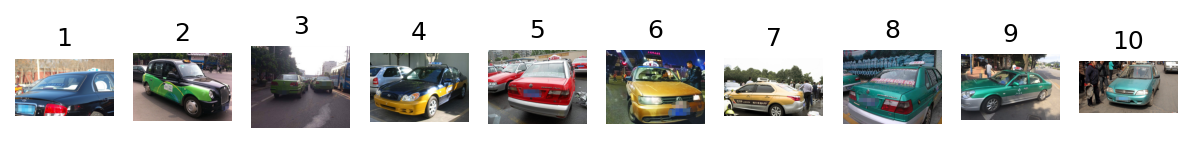

Examples of [truck] cars images


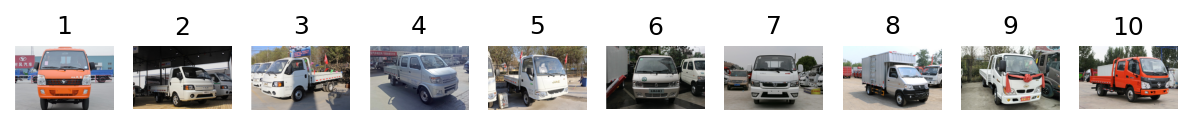

In [14]:
for c in CLASSES.items():
    print(f"Examples of [{c[0]}] cars images")
    show_images(10, train, class_encoded=c[1])

In [16]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

data_path = r"/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/train/content/train"

# Load the Xception model with pre-trained ImageNet weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the full model
pre_trained_model2 = Model(inputs=base_model.input, outputs=predictions)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# Data generators
train_generator_pre2 = datagen.flow_from_directory(data_path, target_size=(224, 224), batch_size=16, class_mode='categorical', subset='training')
validation_generator_pre2 = datagen.flow_from_directory(data_path, target_size=(224, 224), batch_size=16, class_mode='categorical', subset='validation')

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
pre_trained_model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Found 1120 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


In [17]:
with tf.device("/device:GPU:0"):
    # Train the model
    history = pre_trained_model2.fit(train_generator_pre2, validation_data=validation_generator_pre2, epochs=30 , callbacks=[lr_scheduler , early_stopping])


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.4192 - loss: 9.5186 - val_accuracy: 0.6464 - val_loss: 3.6170 - learning_rate: 0.0010
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8312 - loss: 1.2976 - val_accuracy: 0.7071 - val_loss: 2.8085 - learning_rate: 0.0010
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8607 - loss: 0.9795 - val_accuracy: 0.8143 - val_loss: 0.9645 - learning_rate: 0.0010
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.8981 - loss: 0.6414 - val_accuracy: 0.8000 - val_loss: 1.0996 - learning_rate: 0.0010
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9153 - loss: 0.5293 - val_accuracy: 0.8821 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.9463 - loss: 0.4357 - val_accuracy: 0.8714 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9345 - loss: 0.4623 - val_acc

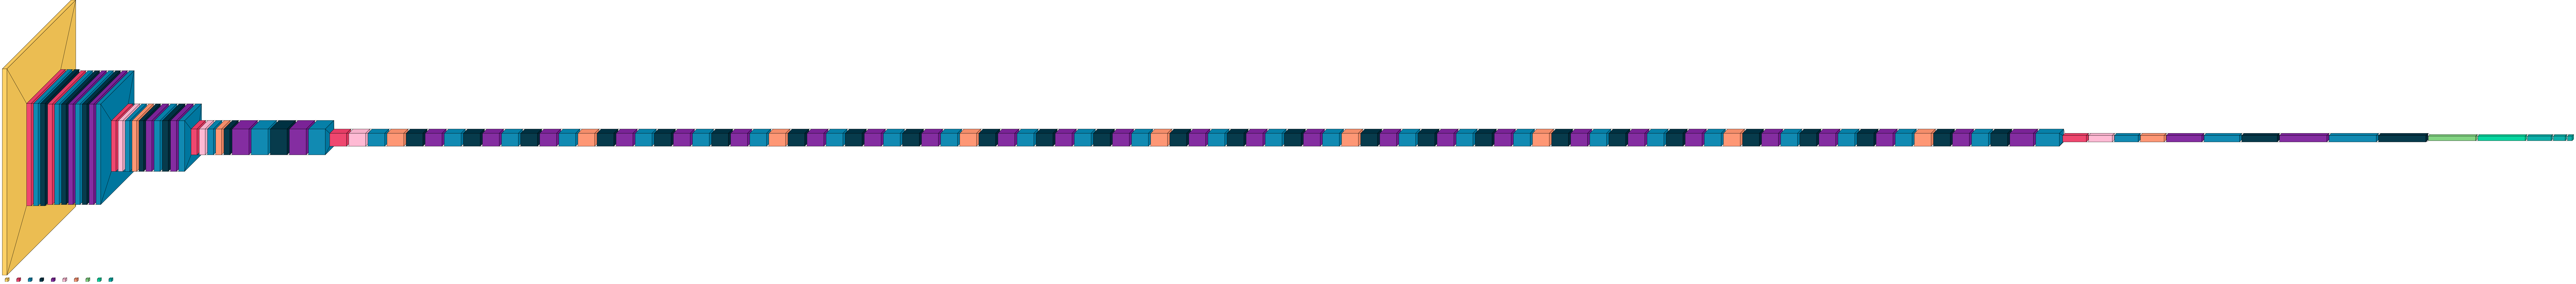

In [18]:
visualkeras.layered_view(pre_trained_model2, legend=True)


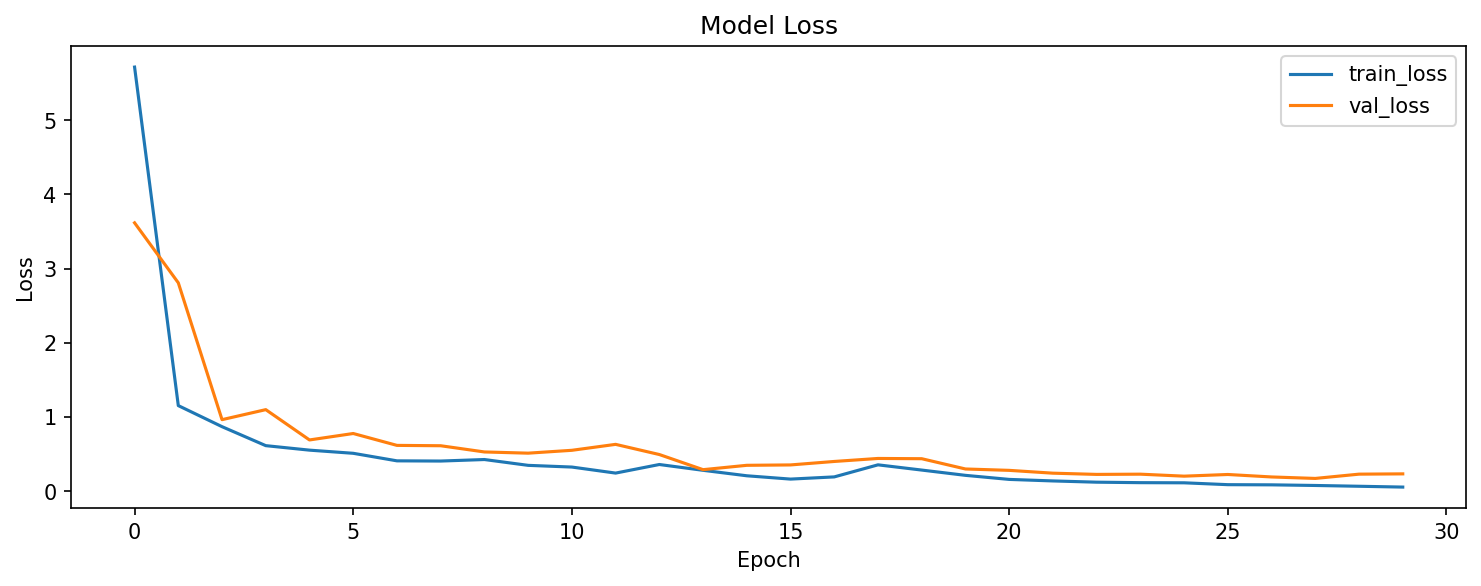

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

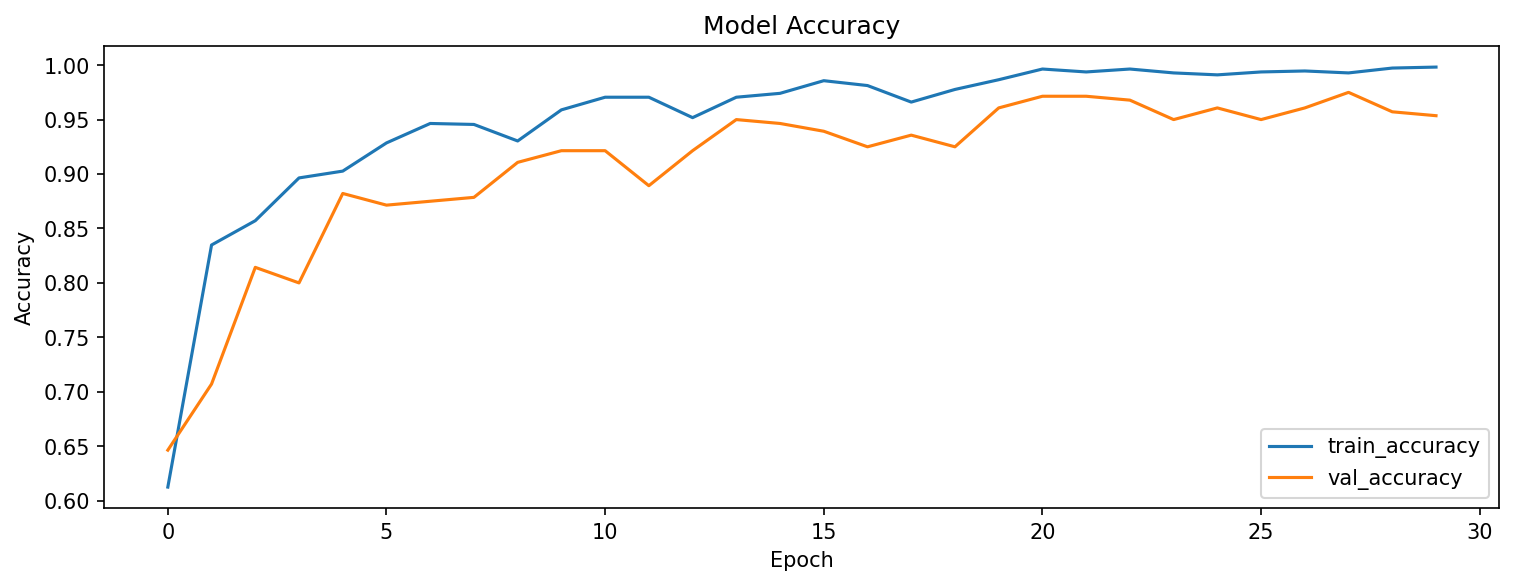

In [20]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [21]:
test.iloc[0,0]


'test/0419f656d61b42a6b2d567ed9ab6673f.jpg'

In [22]:
test_path_perfix

'/kaggle/input/zaka-ambassadors-egypt-vehicle-recognition/test/content/'

In [25]:
def predict_image(filepath, model, target_size=(224, 224)):
    try:
        # Load and preprocess the image
        img = image.load_img(filepath, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values to [0, 1]
        
        # Make prediction
        prediction = model.predict(img_array)
        
        # Assuming it's a classification model, return the predicted class index
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        return predicted_class
    
    except Exception as e:
        print(f"Error processing image: {e}")
        return None


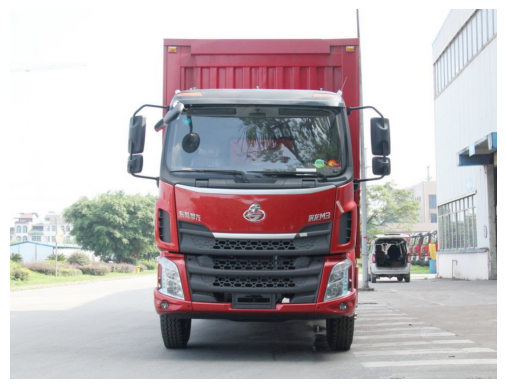

In [26]:
img_test = mpimg.imread(test_path_perfix+test.iloc[0,0])
# Display the image
plt.imshow(img_test)
plt.axis('off')  
plt.show()

In [27]:
predict_image(test_path_perfix+test.iloc[0,0], model=pre_trained_model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


4

In [28]:
# Function to iterate over test dataset and make predictions
def predict_test_dataset(test_data, model):
    predictions = []
    for index, row in test_data.iterrows():
        filepath = test_path_perfix + row[0]  
        prediction = predict_image(filepath, model)
        if prediction is not None:
            predictions.append((row[0], prediction))
    return predictions

# Example usage:
predictions = predict_test_dataset(test, model=pre_trained_model2)

prediction_df = pd.DataFrame(predictions, columns=['path', 'class'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
prediction_df.iloc[0,0]

'test/0419f656d61b42a6b2d567ed9ab6673f.jpg'

In [30]:
test.iloc[0,0]

'test/0419f656d61b42a6b2d567ed9ab6673f.jpg'

In [31]:
prediction_df.to_csv('/kaggle/working/predictions(29).csv', index=False)

In [33]:
CLASSES_reversed = {v: k for k, v in CLASSES.items()}
CLASSES_reversed


CLASSES_REVERSED = {v: k for k, v in CLASSES.items()}

def show_predicted_images(n, dataset, base_path=test_path_perfix, class_encoded=None, MAX_IMGS=200, num_cols=10):
    if n <= MAX_IMGS:
        if class_encoded is not None:
            dataset = dataset[dataset['class'] == class_encoded]

        images = dataset.iloc[:n][['path', 'class_name']].values

        num_rows = (n + num_cols - 1) // num_cols  # Calculate the number of rows needed
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows), dpi=150)

        ax = ax.flatten()  # Flatten the axes array

        for i in range(n):
            img_path = base_path + images[i][0]  # Assuming the file path is in the first column
            img = mpimg.imread(img_path)
            class_label = images[i][1]
            ax[i].imshow(img)
            ax[i].set_title(f"{class_label}")  # Add title with class label
            ax[i].axis('off')

        for j in range(n, num_rows * num_cols):
            ax[j].axis('off')

        plt.show()
    else:
        print('Invalid number of images')

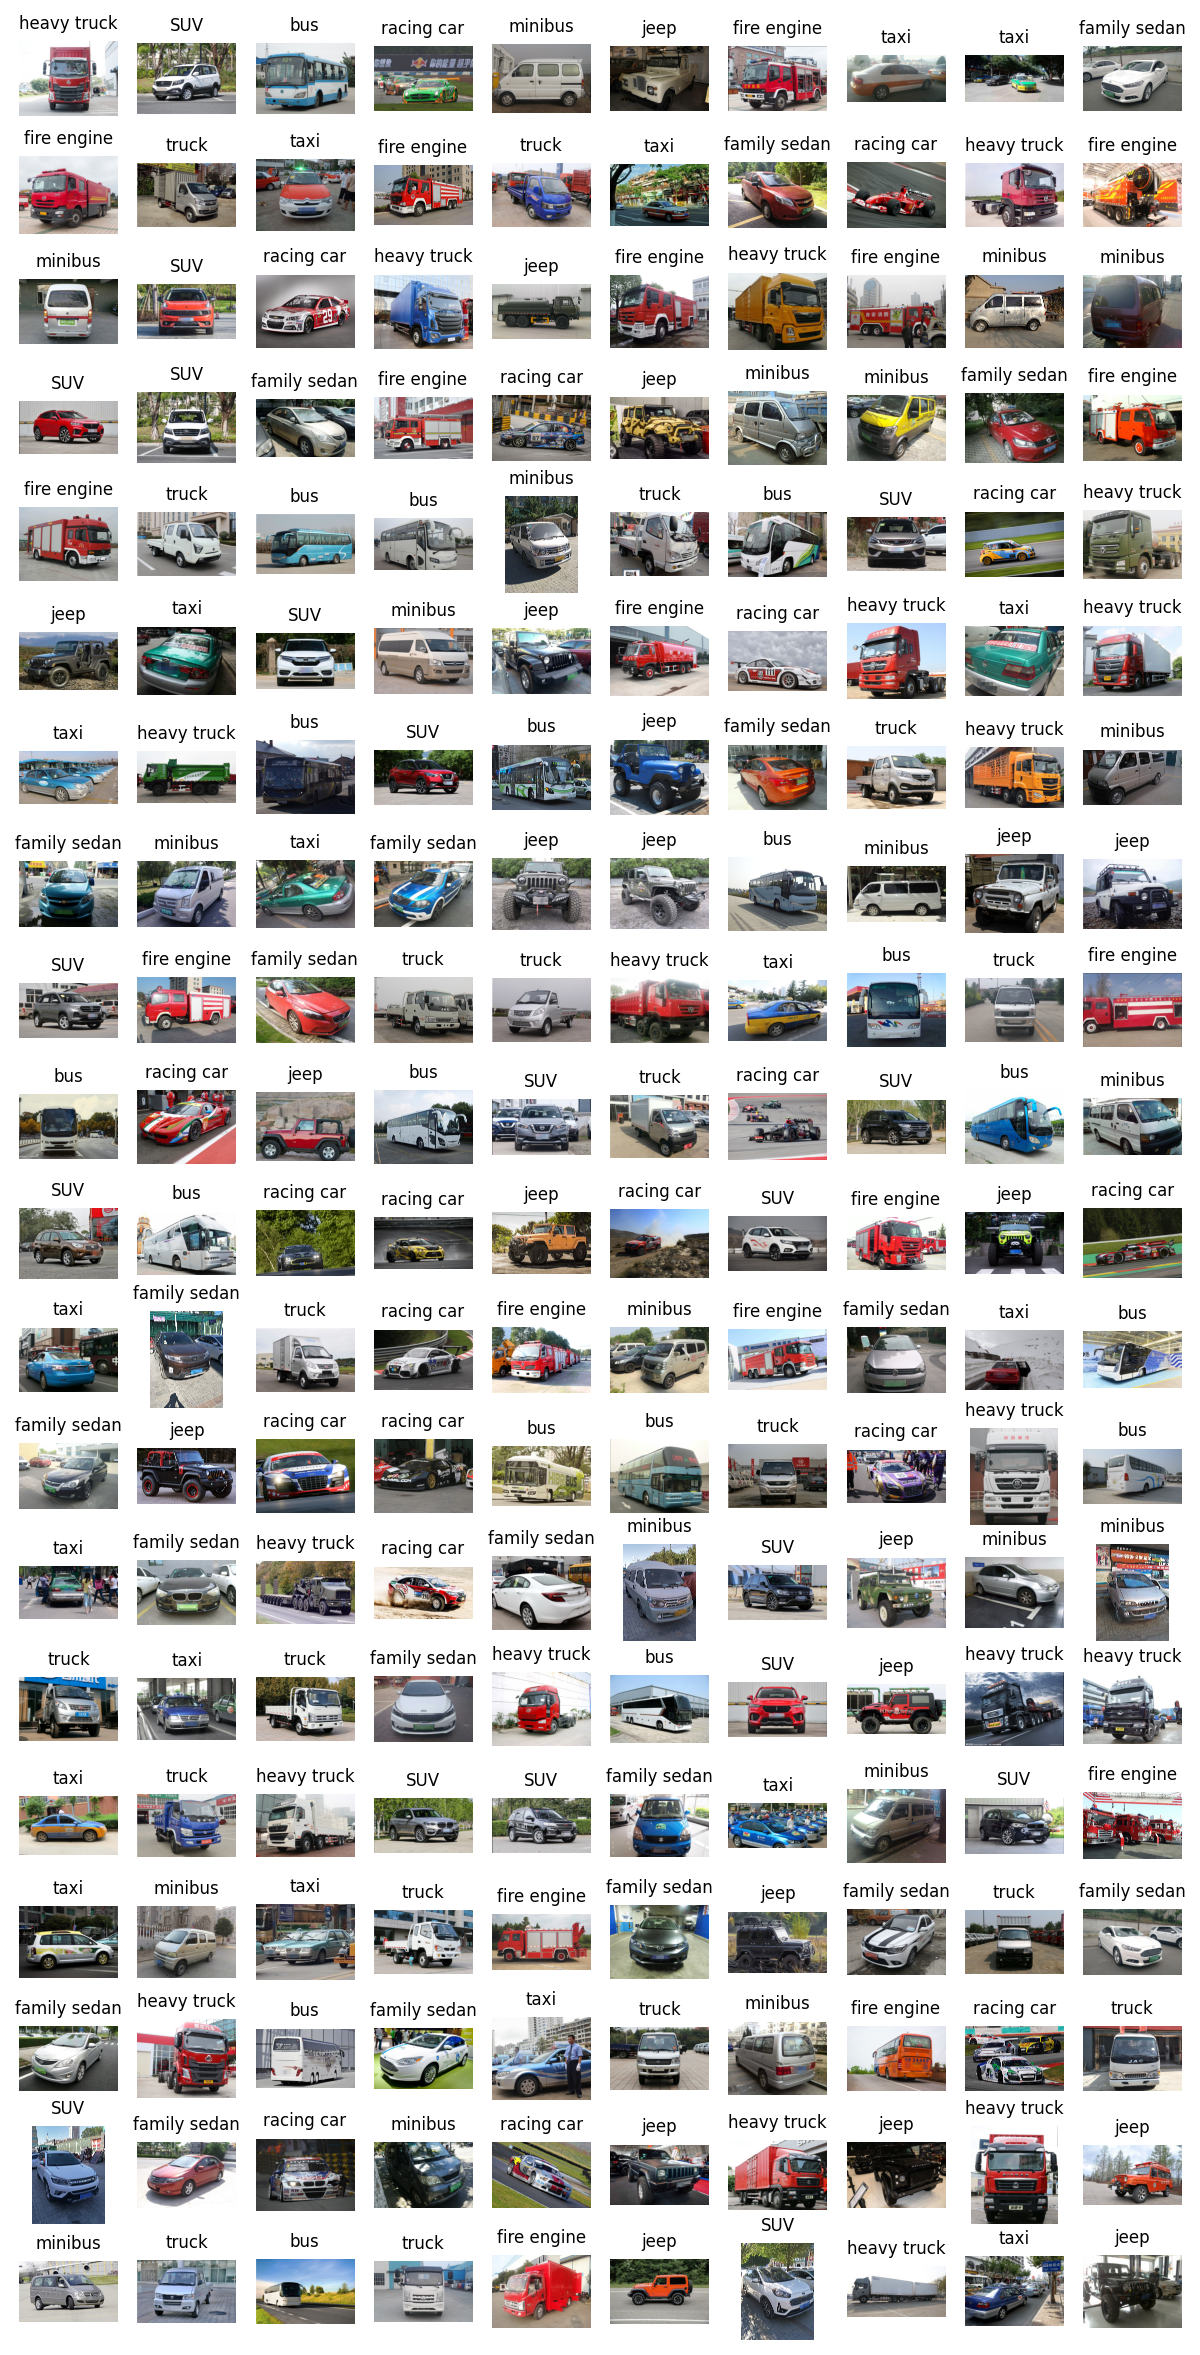

In [34]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 8

df = pd.read_csv(r"/kaggle/working/predictions(29).csv")

df['class_name'] = df['class'].map(CLASSES_REVERSED)


show_predicted_images(200, dataset=df)


# REACH ME VIA : https://www.linkedin.com/in/ehab-mahmoud-ali-77ab0a243/